In [4]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [5]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [6]:
pd.set_option("max_colwidth", 100)

In [7]:
import pyspark 
#sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '16g')])
# here you stop the old spark context with old conf
sc.stop()

Original spark.driver.maxResultSize: 1920m


In [8]:
sc = pyspark.SparkContext(conf=conf)
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

22/12/07 23:55:33 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/07 23:55:33 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/07 23:55:33 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/07 23:55:33 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 16g


In [9]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [10]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [11]:
# import pyspark 
# #sc = spark.sparkContext
# print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
# conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '16g')])
# # here you stop the old spark context with old conf
# sc.stop()

In [8]:
# sc = pyspark.SparkContext(conf=conf)
#print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

In [11]:
#spark = SparkSession.builder.getOrCreate()

In [12]:
df = spark.read.json('gs://msca-bdp-tweets/final_project')

22/12/03 22:51:34 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


In [6]:
df.count()

99992797

In [11]:
df.columns

['coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_text',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_from',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'tweet_text',
 'user',
 'withheld_copyright',
 'withheld_in_countries']

In [13]:
df_m = df.withColumn('verified_user',df.user['verified'])

In [14]:
df_m2 = df_m.withColumn('description',df.user['description'])

In [16]:
df_m3 = df_m2.withColumn('user_id',df.user['id'])

In [19]:
df_m4 = df_m3.withColumn('user_screen_name',df.user['screen_name'])

In [20]:
df_m5 = df_m4.withColumn('retweeted_user_id',df.retweeted_status.user['id']).\
              withColumn('retweeted_user_screen_name',df.retweeted_status.user['screen_name']).\
              withColumn('retweeted_user_description',df.retweeted_status.user['description'])

In [22]:
df_m6 = df_m5.select('created_at','user_id','lang','text','verified_user','description',
                     'retweeted_user_id','retweeted_user_screen_name','retweeted_user_description',
                     'retweeted_status','retweeted','user_screen_name','quoted_status','place','coordinates')


In [17]:
df_m6.show(5)

+--------------------+-------------------+----+--------------------+-------------+--------------------+-----------------+--------------------------+--------------------------+--------------------+---------+----------------+-------------+-----+-----------+
|          created_at|            user_id|lang|                text|verified_user|         description|retweeted_user_id|retweeted_user_screen_name|retweeted_user_description|    retweeted_status|retweeted|user_screen_name|quoted_status|place|coordinates|
+--------------------+-------------------+----+--------------------+-------------+--------------------+-----------------+--------------------------+--------------------------+--------------------+---------+----------------+-------------+-----+-----------+
|Tue May 24 22:09:...|           22983536|  en|RT @ABC: “Why are...|        false|      💙⚾️💛🏀💜🏒🖤|         28785486|                       ABC|      All the news and ...|{null, Tue May 24...|       RT|         shiaoma|         null| 

### Filter whole dataset

In [23]:
df_tweets_en = df_m6.filter(df_m6.lang == 'en')
#choose all the english tweets 

In [24]:
#df_tweets_verified = df_tweets_en.filter(df_tweets_en.verified_user == 'true')
# filter all the verified users 

In [26]:
df_tweets_key = df_tweets_en.filter(lower(col('text')).contains('teach')|\
                                    lower(col('text')).contains('primary school')|\
                                    lower(col('text')).contains('instruction')|\
                                    lower(col('text')).contains('curriculum')|\
                                    lower(col('text')).contains('learning')|\
                                    lower(col('text')).contains('college')|\
                                    lower(col('text')).contains('university')|\
                                    lower(col('text')).contains('kindergarten')|\
                                    lower(col('text')).contains('secondary school')|\
                                    lower(col('text')).contains('high school')|\
                                    lower(col('text')).contains('tuition')|\
                                    lower(col('text')).contains('course')|\
                                    lower(col('text')).contains('textbook')|\
                                    lower(col('text')).contains('undergrad')|\
                                    lower(col('text')).contains('instructor')|\
                                    lower(col('text')).contains('primary education')|\
                                    lower(col('text')).contains('secondary education')|\
                                    lower(col('text')).contains('student')|\
                                    lower(col('text')).contains('literacy')|\
                                     lower(col('text')).contains('math'))
#filter all the tweets that are related to education, use keyword related to education

In [ ]:
#write the filtered dataset into parquet to increase efficieny.
df_tweets_key.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/xingchenwang/df_location')

In [11]:
df_tweets_key = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/xingchenwang/df_location/')

In [27]:
df_tweets_key.count()

39067882

### 4b Where are these Twitterers (all of them, not just influencers) located?

In [43]:
df_country = df_tweets_key.withColumn('place_country',df_tweets_key.place['country'])
df_country = df_country.filter(df_country.place_country.isNotNull())

In [44]:
df_place_country = df_country.groupby('place_country').agg(count('*').alias('count'))
df_place_country.orderBy('count',ascending=False).show(10)

+--------------------+------+
|       place_country| count|
+--------------------+------+
|       United States|249091|
|               India| 22381|
|      United Kingdom| 19881|
|Kingdom of Saudi ...| 11695|
|              Canada|  8498|
|             Nigeria|  7877|
|            Pakistan|  3342|
|        South Africa|  3329|
|           Australia|  3267|
|Republic of the P...|  3119|
+--------------------+------+
only showing top 10 rows



In [45]:
df_place_country.count()

410

In [46]:
#obtain longitude and latitude from place column
df_country = df_tweets_key.withColumn('place_country',df_tweets_key.place['country']).\
             withColumn('country_longitude',df_tweets_key.place.bounding_box['coordinates'][0][0][0]).\
             withColumn('country_latitude',df_tweets_key.place.bounding_box['coordinates'][0][0][1])
df_country = df_country.filter(df_country.place_country.isNotNull())
df_place_country = df_country.groupby(['place_country','country_longitude','country_latitude']).agg(count('*').alias('count'))
df_country_s = df_place_country.orderBy('count',ascending=False)
df_country_s = df_country_s.dropDuplicates(['place_country'])

In [47]:
df_country_s.count() 

410

In [48]:
df_country_sp = df_country_s.toPandas()

In [49]:
df_country_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   place_country      410 non-null    object 
 1   country_longitude  410 non-null    float64
 2   country_latitude   410 non-null    float64
 3   count              410 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 12.9+ KB


In [50]:
df_country_sp.head(5)

,place_country,country_longitude,country_latitude,count
0,Islamic Republic of Iran,44.032478,25.010672,72
1,Sweden,17.760132,59.227138,64
2,The Netherlands,4.728900,52.278227,58
3,Suécia,17.080050,59.730690,1
4,Côte d'Ivoire,-8.601243,4.361655,1


In [51]:
df_country_sp.describe()

,country_longitude,country_latitude,count
count,410.000000,410.000000,410.000000
mean,18.709657,25.979878,39.553659
std,62.362825,25.132579,376.752373
min,-180.000000,-89.999900,1.000000
25%,-0.449118,10.806088,1.000000
50%,17.436101,30.864289,2.000000
75%,42.010156,46.091818,8.000000
max,178.437646,69.282103,7131.000000


### Convert pandas dataframe to geopandas dataframe to plot maps

In [54]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_country_sp.country_longitude, df_country_sp.country_latitude)]
#df = df_coordinates_pdp.drop(['longitude', 'latitude'], axis=1)
gdf2 = GeoDataFrame(df_country_sp, crs="EPSG:4326", geometry=geometry)

In [55]:
gdf2.head(5)

,place_country,country_longitude,country_latitude,count,geometry
0,Islamic Republic of Iran,44.032478,25.010672,72,POINT (44.03248 25.01067)
1,Sweden,17.760132,59.227138,64,POINT (17.76013 59.22714)
2,The Netherlands,4.728900,52.278227,58,POINT (4.72890 52.27823)
3,Suécia,17.080050,59.730690,1,POINT (17.08005 59.73069)
4,Côte d'Ivoire,-8.601243,4.361655,1,POINT (-8.60124 4.36165)


In [56]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [57]:
world = world.rename(columns={'name':'place_country'})

In [58]:
world.head(5)

,pop_est,continent,place_country,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.012..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948, -8.68440 27.39574, -8.68729 25.88106, -11.96942 ..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.97421 49.00254, -124.91024 49.98456, -125.62461 50.416..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.00000 49.00000, -117.03121 49.00000, -116.04818 49.000..."


In [59]:
m1 = world.sjoin(gdf2,how="inner", predicate='intersects')

In [60]:
m1.describe()

,pop_est,gdp_md_est,index_right,country_longitude,country_latitude,count
count,2.920000e+02,2.920000e+02,292.000000,292.000000,292.000000,292.000000
mean,1.192980e+08,1.438397e+06,208.763699,25.617407,30.232834,24.023973
std,2.991051e+08,3.164354e+06,121.745336,51.184738,22.799392,158.721490
min,3.613130e+05,1.879000e+03,0.000000,-123.224215,-46.052058,1.000000
25%,9.960121e+06,9.386250e+04,99.750000,4.743506,15.774691,1.000000
50%,3.426853e+07,4.450750e+05,213.500000,20.005981,36.919072,1.000000
75%,8.313280e+07,1.646739e+06,314.250000,42.010156,47.731389,6.000000
max,1.397715e+09,2.143323e+07,409.000000,178.437646,64.140317,2046.000000


In [ ]:
# there are plenty of nulls in the place's coordinate so the count just reduced on the graph.

In [62]:
import matplotlib.pyplot as plt

/opt/conda/miniconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/miniconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:title={'center':'Geographical Distribution of Twitters'}>

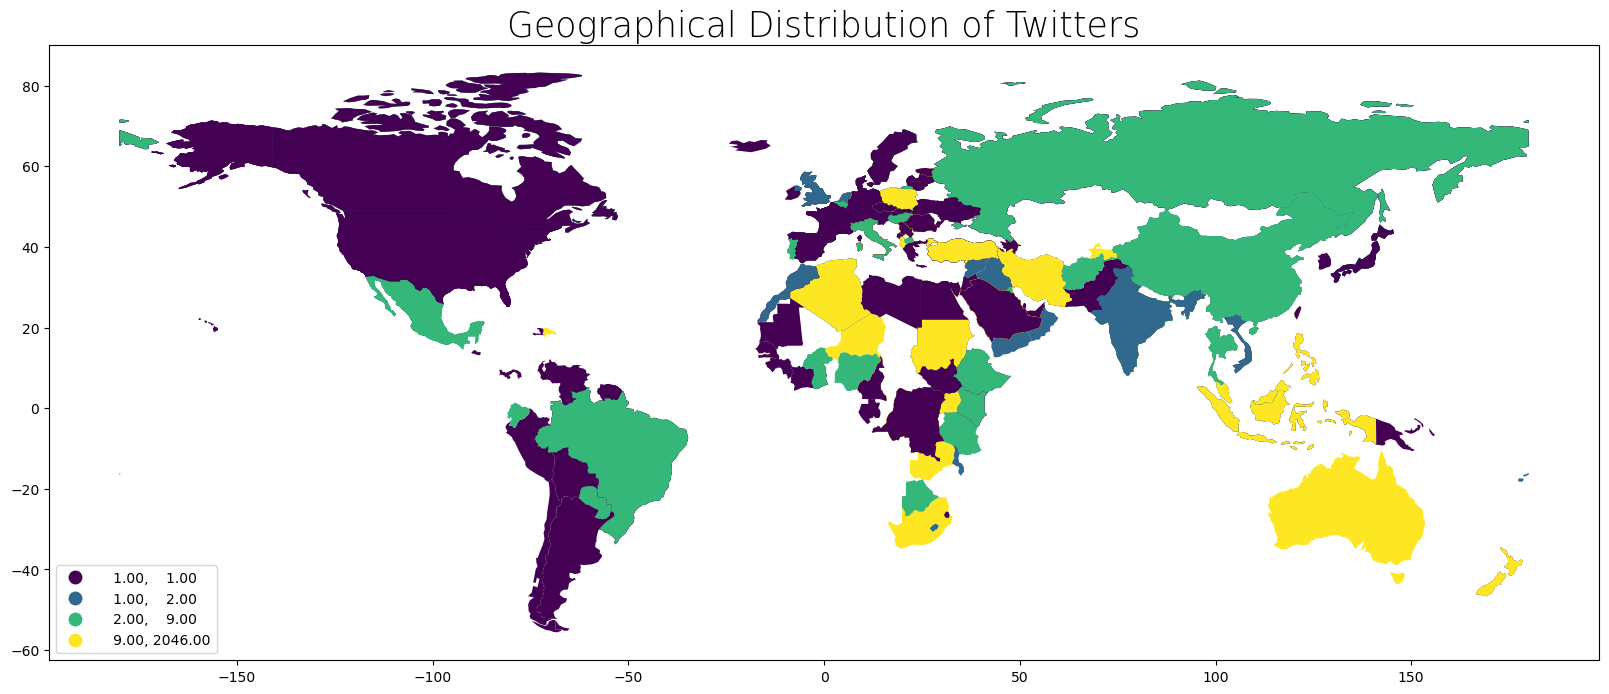

In [63]:
fig, ax = plt.subplots(1, figsize=(20, 8))
title = 'Geographical Distribution of Twitters'
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
m1.plot(column='count',ax =ax,legend = True,legend_kwds={'loc': 'lower left'},scheme='quantiles')


<AxesSubplot:title={'center':'Geographical Distribution of Twitters'}>

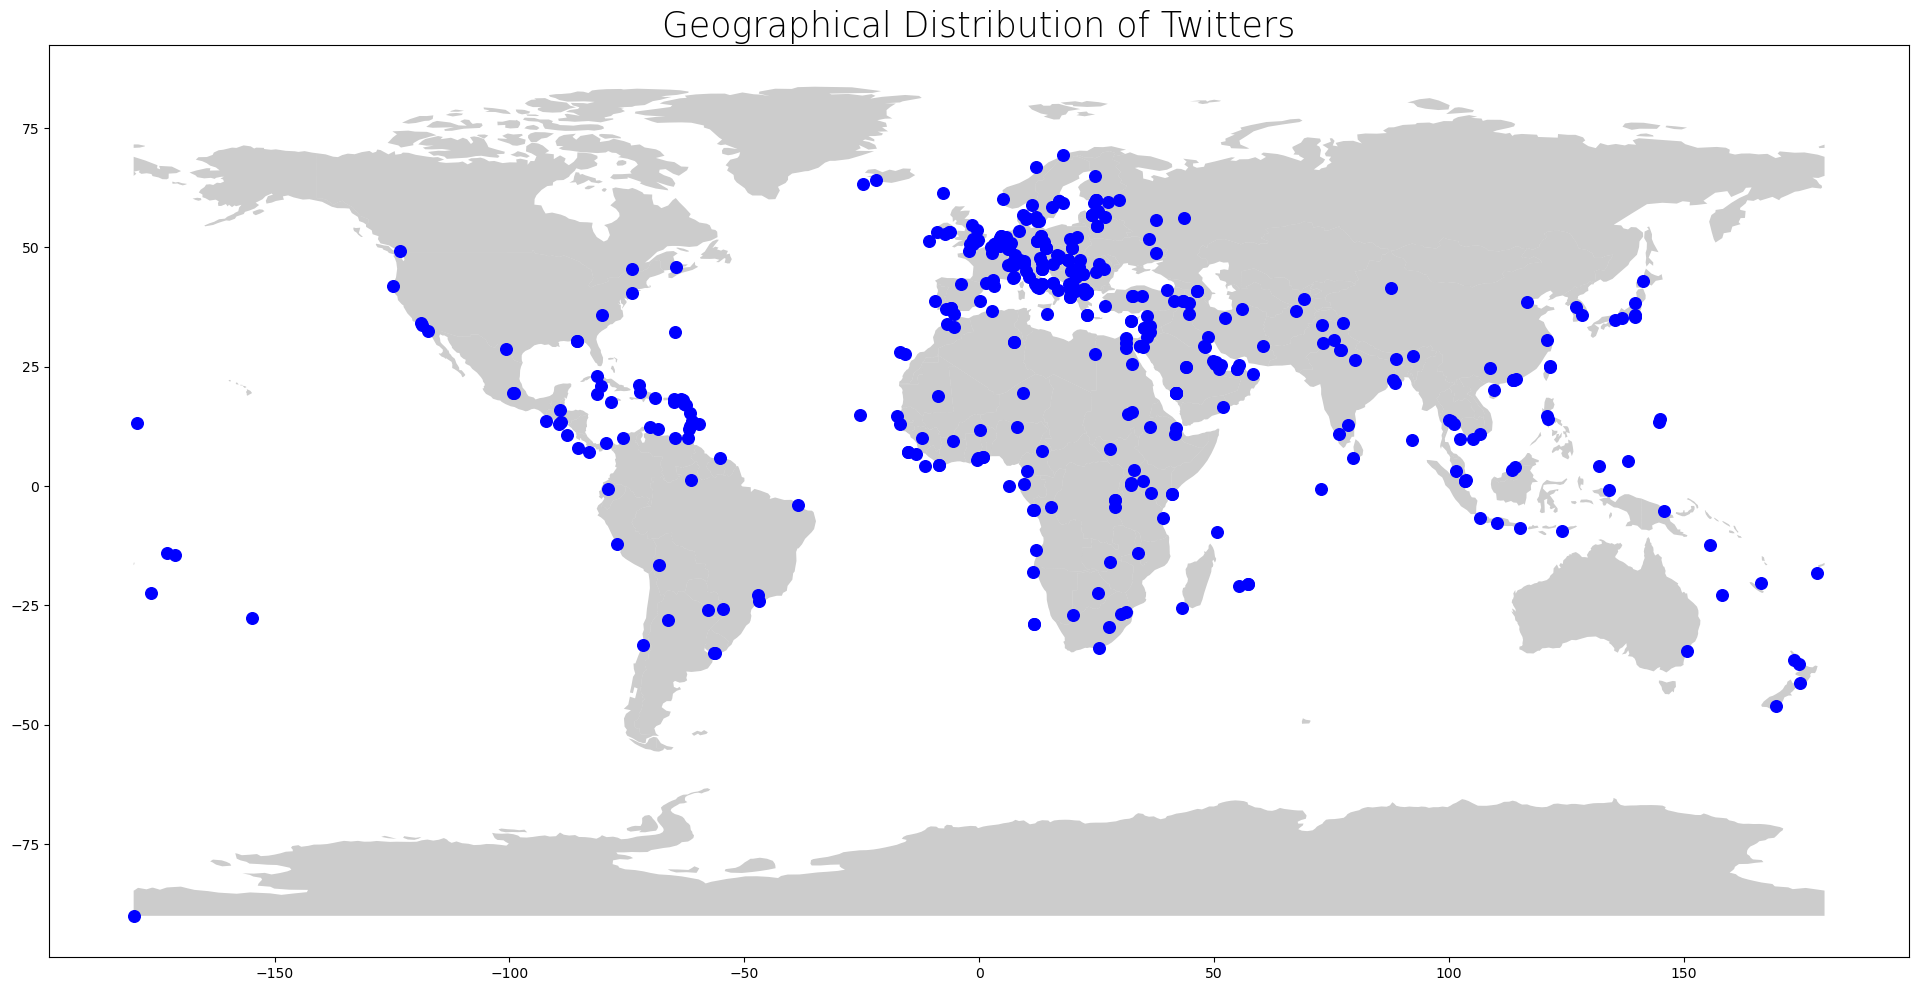

In [64]:
fig, ax = plt.subplots(figsize=(24, 18))
title = 'Geographical Distribution of Twitters'
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
base = world.plot(ax=ax, alpha=0.4, color="grey")

gdf2.plot(ax=base, marker='o', color='blue', markersize=70)

### 4a Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?

#### Choose keyword primary school

In [9]:
df_tweets_key_primary = df_tweets_key.filter(lower(col('text')).contains('primary school'))

In [142]:
df_tweets_key_primary.count()

631549

In [10]:
df_tweets_key_primary = df_tweets_key_primary.withColumn('month_day',substring(col('created_at'),4,7)).\
                                              withColumn('year',df_tweets_key_primary['created_at'][26:30])
df_tweets_key_primary = df_tweets_key_primary.withColumn('year',df_tweets_key_primary['year'].cast(IntegerType()))
                             
df_tweets_key_primary=df_tweets_key_primary.withColumn('old_date',concat_ws(' ',df_tweets_key_primary.month_day,df_tweets_key_primary.year))

df_tweets_key_primary = df_tweets_key_primary.withColumn('date',to_date(col("old_date")," MMM dd yyyy"))
    

In [11]:
df_tweets_key_primary = df_tweets_key_primary.drop('month_day','year','old_date')

In [13]:
df_primary_p = df_tweets_key_primary.groupby('date').agg(count('*').alias('count'))

In [269]:
df_primary_p.count()

216

In [14]:
df_primary_pd = df_primary_p.toPandas()

In [271]:
df_primary_pd.head(5)

,date,count
0,2022-08-02,2555
1,2022-07-27,2366
2,2022-05-19,2714
3,2022-07-07,2185
4,2022-08-11,1502


In [15]:
df_primary_pd.sort_values(by='count',ascending=False).head(5)

,date,count
208,2022-05-25,35392
109,2022-08-09,9669
183,2022-11-02,7290
10,2022-10-19,6452
9,2022-05-26,6147


<AxesSubplot:title={'center':'Emergence of new issues related to primary school'}, xlabel='date'>

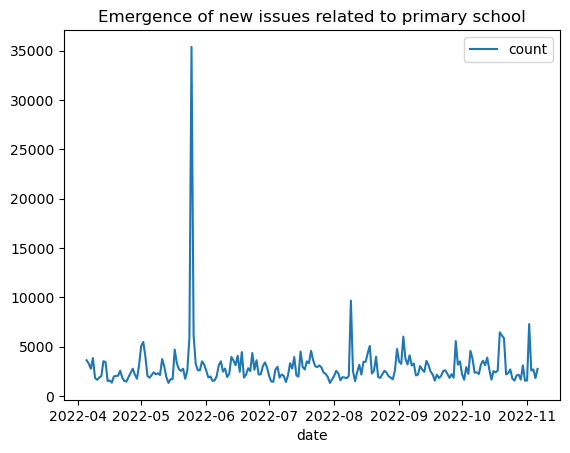

In [32]:
df_primary_pd.plot(y='count',x='date',title = 'Emergence of new issues related to primary school')



In [16]:
df_tweets_key_primary = df_tweets_key_primary.withColumn('place_country',df_tweets_key_primary.place['country'])


In [22]:
l = ['2022-05-25','2022-08-09','2022-11-02','2022-10-19','2022-05-26']
df_primary_ps = df_tweets_key_primary.filter(df_tweets_key_primary.date.isin(l))
df_primary_psg = df_primary_ps.groupby('place_country').agg(count('*').alias('count'))
df_primary_psg = df_primary_psg.filter(df_primary_psg.place_country.isNotNull())
# this reduces a lot of lines 
df_primary_psg.orderBy('count',ascending=False).show(5)

+--------------+-----+
| place_country|count|
+--------------+-----+
|United Kingdom|   61|
|         Kenya|   60|
|       Nigeria|   14|
|     Australia|   14|
| United States|   11|
+--------------+-----+
only showing top 5 rows



#### Choose keyword math

In [12]:
df_tweets_key_math = df_tweets_key.filter(lower(col('text')).contains('math'))

In [13]:
df_tweets_key_math = df_tweets_key_math.withColumn('month_day',substring(col('created_at'),4,7)).\
                                              withColumn('year',df_tweets_key_math['created_at'][26:30])
df_tweets_key_math = df_tweets_key_math.withColumn('year',df_tweets_key_math['year'].cast(IntegerType()))
                             
df_tweets_key_math=df_tweets_key_math.withColumn('old_date',concat_ws(' ',df_tweets_key_math.month_day,df_tweets_key_math.year))

df_tweets_key_math= df_tweets_key_math.withColumn('date',to_date(col("old_date")," MMM dd yyyy"))

In [14]:
df_tweets_key_math = df_tweets_key_math.drop('month_day','year','old_date')

In [16]:
df_math_p = df_tweets_key_math.groupby('date').agg(count('*').alias('count'))

In [17]:
#df_textbook_p = df_tweets_key_primary.groupby('date').agg(count('*').alias('count'))
df_math_p.count()

216

In [18]:
df_math_pd = df_math_p.toPandas()

In [20]:
df_math_pd.sort_values(by='count',ascending=False).head(5)

,date,count
207,2022-05-25,16767
59,2022-06-23,13970
28,2022-04-18,9357
100,2022-07-17,7802
62,2022-04-19,7060


<AxesSubplot:title={'center':'Emergence of new issues related to math'}, xlabel='date'>

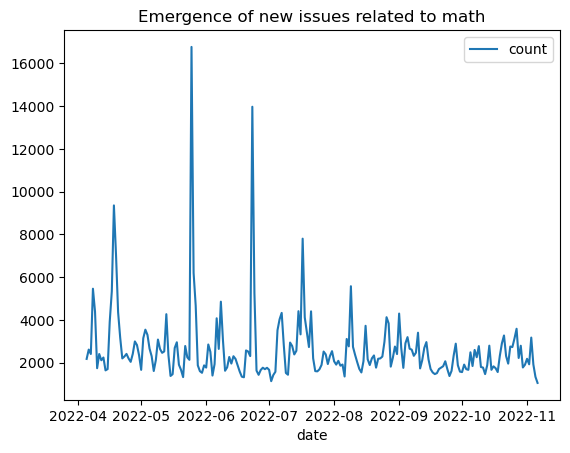

In [19]:
df_math_pd.plot(y='count',x='date',title = 'Emergence of new issues related to math')

In [26]:
df_tweets_key_math.filter(df_tweets_key_math.date == '2022-04-18').show(5)

22/12/08 00:19:38 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670422706346_0008_01_000051 on host: hub-msca-bdp-dphub-students-xingchenwang-sw-nt7l.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 00:19:38.475]Container killed on request. Exit code is 143
[2022-12-08 00:19:38.475]Container exited with a non-zero exit code 143. 
[2022-12-08 00:19:38.493]Killed by external signal
.
22/12/08 00:19:38 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 51 for reason Container from a bad node: container_1670422706346_0008_01_000051 on host: hub-msca-bdp-dphub-students-xingchenwang-sw-nt7l.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 00:19:38.475]Container killed on request. Exit code is 143
[2022-12-08 00:19:38.475]Container exited with a non-zero exit code 143. 
[2022-12-08 00:19:38.493]Killed by external signal
.
22/12/08 00:19

+--------------------+-------------------+----+--------------------+-------------+--------------------+------------------+--------------------------+--------------------------+--------------------+---------+----------------+-------------+-----+-----------+---------------+------------------------------+------------+----------+-------------+
|          created_at|            user_id|lang|                text|verified_user|         description| retweeted_user_id|retweeted_user_screen_name|retweeted_user_description|    retweeted_status|retweeted|user_screen_name|quoted_status|place|coordinates|followers_count|retweeted_user_followers_count|    Category|      date|place_country|
+--------------------+-------------------+----+--------------------+-------------+--------------------+------------------+--------------------------+--------------------------+--------------------+---------+----------------+-------------+-----+-----------+---------------+------------------------------+------------+

In [22]:
df_tweets_key_math = df_tweets_key_math.withColumn('place_country',df_tweets_key_math.place['country'])

In [23]:
l2= ['2022-05-25','2022-06-23','2022-04-18','2022-07-17','2022-04-19']
df_math_ps = df_tweets_key_math.filter(df_tweets_key_math.date.isin(l2))
df_math_psg = df_math_ps.groupby('place_country').agg(count('*').alias('count'))
df_math_psg = df_math_psg.filter(df_math_psg.place_country.isNotNull())
# this reduces a lot of lines 
df_math_psg.orderBy('count',ascending=False).show(5)

+--------------+-----+
| place_country|count|
+--------------+-----+
| United States|   70|
|         India|   16|
|United Kingdom|    7|
|         Kenya|    6|
|       Nigeria|    4|
+--------------+-----+
only showing top 5 rows



#### There is a relationship between the emergence of new issues in education and progression and locations of these Twitterers, twitter users in the US pay more attention to the Uvalde school shooting.

### 5. What are the timelines of these tweets? Do you see significant peaks and valleys?

In [ ]:
df_tweets_key = df_tweets_key.withColumn('month_day',substring(col('created_at'),4,7)).\
                                              withColumn('year',df_tweets_key['created_at'][26:30])
df_tweets_key= df_tweets_key.withColumn('year',df_tweets_key['year'].cast(IntegerType()))
                             
df_tweets_key=df_tweets_key.withColumn('old_date',concat_ws(' ',df_tweets_key.month_day,df_tweets_key.year))

df_tweets_key = df_tweets_key.withColumn('date',to_date(col("old_date")," MMM dd yyyy"))

In [16]:
df_tweets_key = df_tweets_key.drop('month_day','year','old_date')

In [17]:
df_tweets_key_p = df_tweets_key.groupby('date').agg(count('*').alias('count'))

In [283]:
#df_tweets_key_p = df_tweets_key.groupby('date').agg(count('*').alias('count'))
df_tweets_key_p.count()

216

In [18]:
df_tweets_key_pd = df_tweets_key_p.toPandas()

In [17]:
df_tweets_key_pd.sort_values(by='count',ascending=False).head(10)

,date,count
65,2022-08-25,339258
121,2022-08-26,287631
178,2022-08-24,273366
131,2022-10-03,267895
205,2022-10-02,265990
181,2022-04-28,259710
123,2022-05-12,252395
9,2022-06-06,250861
213,2022-05-25,245181
12,2022-05-26,241813


In [18]:
df_tweets_key_pd.sort_values(by='count').head(10)

,date,count
40,2022-06-19,101022
39,2022-07-24,103502
42,2022-07-10,109586
144,2022-07-23,110661
47,2022-07-16,111124
91,2022-07-03,113377
80,2022-07-02,115636
207,2022-04-17,118461
107,2022-07-04,119029
100,2022-07-17,119176


<AxesSubplot:title={'center':'Timeline of tweets'}, xlabel='date'>

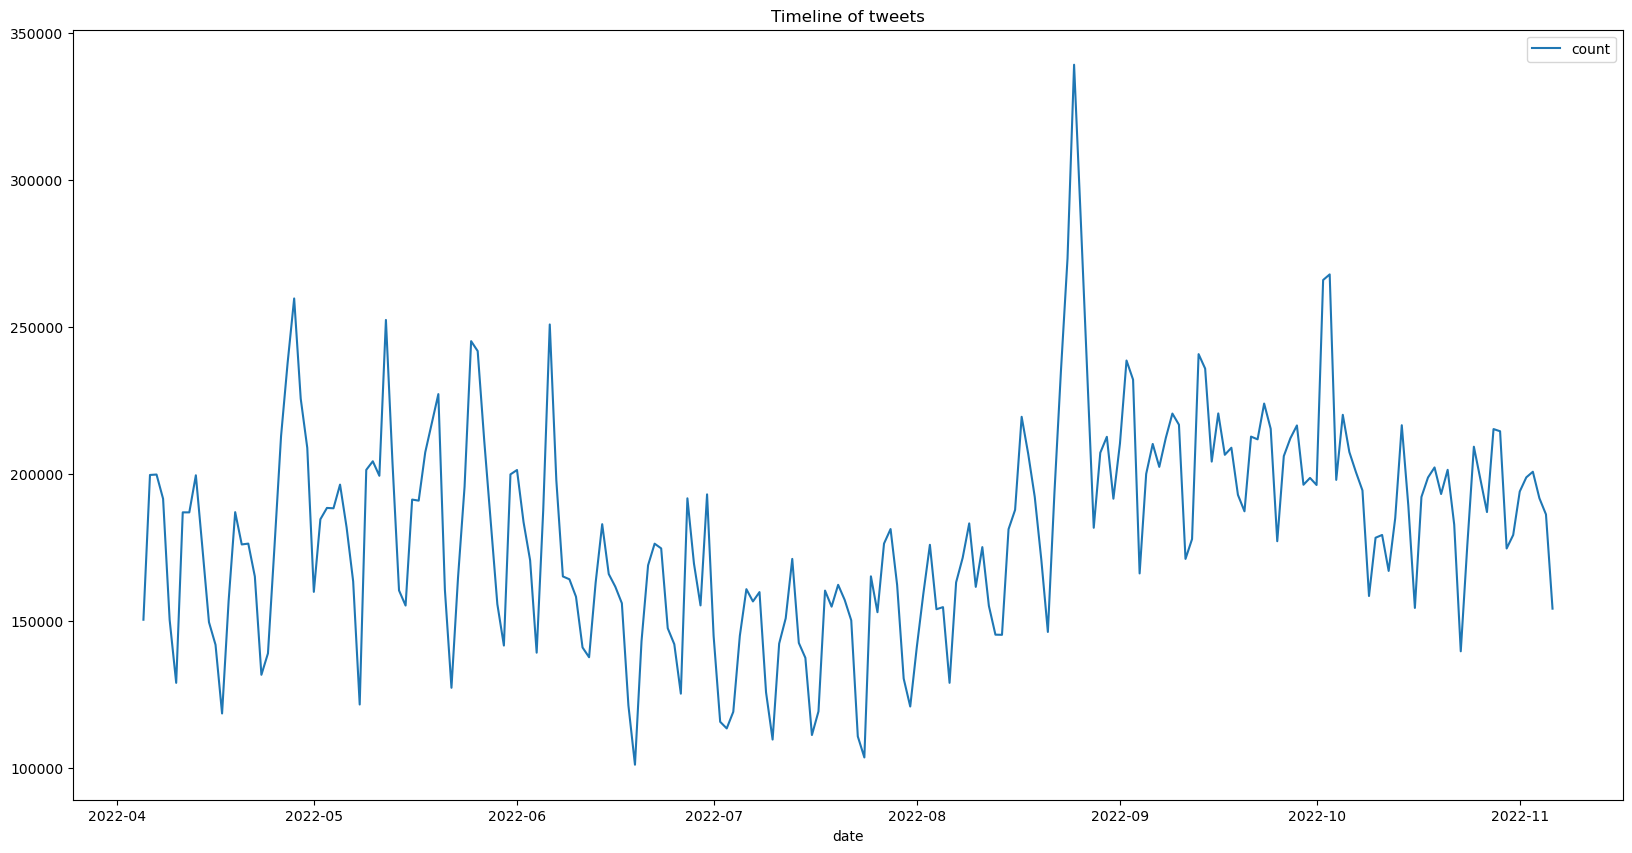

In [19]:
df_tweets_key_pd.plot(y='count',x='date',title = 'Timeline of tweets',figsize=(20,10))


#### When the Uvalde school shooting and florida math book ban happened, there was a peak in May. The data collection gap may occur around July since the tweet count is quite low during this time.